<a href="https://colab.research.google.com/github/jessteoxizhi/FintechSocietyFraudDetection/blob/master/Fintech_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FRAUD DETECTION
---


## Table of Contents
1. Problem Description (Brief Write Up)
2. Exploratory Data Analysis (EDA)
3. Data Pre-processing
4. Model Selection
5. Evaluation
6. Discussion and Possible Improvements

## 1. Problem Description

### Context

There is a lack of public available datasets on financial services and specially in the emerging mobile money transactions domain. Financial datasets are important to many researchers and in particular to us performing research in the domain of fraud detection. Part of the problem is the intrinsically private nature of financial transactions, that leads to no publicly available datasets.

We present a synthetic dataset generated using the simulator called PaySim as an approach to such a problem. PaySim uses aggregated data from the private dataset to generate a synthetic dataset that resembles the normal operation of transactions and injects malicious behaviour to later evaluate the performance of fraud detection methods.

### Content

PaySim simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world.

This synthetic dataset is scaled down 1/4 of the original dataset and it is created just for Kaggle.



### Headers

This is a sample of 1 row with headers explanation:

1,PAYMENT,1060.31,C429214117,1089.0,28.69,M1591654462,0.0,0.0,0,0

**step** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

**type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

**amount** - amount of the transaction in local currency.

**nameOrig** - customer who started the transaction

**oldbalanceOrg** - initial balance before the transaction

**newbalanceOrig** - new balance after the transaction

**nameDest** - customer who is the recipient of the transaction

**oldbalanceDest** - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

**newbalanceDest** - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

**isFraud** - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

**isFlaggedFraud** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

## 2. Exploratory Data Analysis

The provided data has the financial transaction data as well as the target variable isFraud, which is the actual fraud status of the transaction and isFlaggedFraud is the indicator which the simulation is used to flag the transaction using some threshold.

The goal should be how we can improve and come up with better threshold to capture the fraud transaction.

### Importing packages and the dataset

In [0]:
import pandas as pd
import numpy as np

#!pip install matplotlib
import matplotlib.pyplot as plt

#!pip install seaborn
import seaborn as sns

#!pip install plotly
from plotly import tools

# import train test split
from sklearn.model_selection import train_test_split, learning_curve

# import metrics
from sklearn.metrics import average_precision_score, f1_score

# import logistic regression
from sklearn.linear_model import LogisticRegression

# import SVM
from sklearn.ensemble import RandomForestClassifier

In [0]:
#installing and importing packages to link to dataset on drive
!pip install PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
#getting access token for drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#downloading dataset from drive
download = drive.CreateFile({'id': '1vKkYiVGys6ShYYD7AuvRK1BBJ02okOLz'})
download.GetContentFile('FraudData.tar')

In [0]:
#reading dataset
df = pd.read_csv('FraudData.tar')
#reshaping data
df.rename(columns = {df.columns[0]: "step"} , inplace = True)
#showing first few data
df.head(10)




,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1.0,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0.0,0.0
1,1.0,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0.0,0.0
2,1.0,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1.0,0.0
3,1.0,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1.0,0.0
4,1.0,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0.0,0.0
5,1.0,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0.0,0.0
6,1.0,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0.0,0.0
7,1.0,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0.0,0.0
8,1.0,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0.0,0.0
9,1.0,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0.0,0.0


In [0]:
#Quickly look at the dataset sample and other properties.
print(df.head(5))
print(df.describe())
print(df.info())


   step      type    amount  ... newbalanceDest  isFraud  isFlaggedFraud
0   1.0   PAYMENT   9839.64  ...            0.0      0.0             0.0
1   1.0   PAYMENT   1864.28  ...            0.0      0.0             0.0
2   1.0  TRANSFER    181.00  ...            0.0      1.0             0.0
3   1.0  CASH_OUT    181.00  ...            0.0      1.0             0.0
4   1.0   PAYMENT  11668.14  ...            0.0      0.0             0.0

[5 rows x 11 columns]
               step        amount  ...       isFraud  isFlaggedFraud
count  6.362620e+06  6.362620e+06  ...  6.362620e+06    6.362620e+06
mean   2.433972e+02  1.798619e+05  ...  1.290820e-03    2.514687e-06
std    1.423320e+02  6.038582e+05  ...  3.590480e-02    1.585775e-03
min    1.000000e+00  0.000000e+00  ...  0.000000e+00    0.000000e+00
25%    1.560000e+02  1.338957e+04  ...  0.000000e+00    0.000000e+00
50%    2.390000e+02  7.487194e+04  ...  0.000000e+00    0.000000e+00
75%    3.350000e+02  2.087215e+05  ...  0.000000e+00    

In [0]:
#check for null values
print(df.isnull().sum())

step              1
type              1
amount            1
nameOrig          1
oldbalanceOrg     1
newbalanceOrig    1
nameDest          1
oldbalanceDest    1
newbalanceDest    1
isFraud           1
isFlaggedFraud    1
dtype: int64


In [0]:
#view NA values
df[df["step"].isnull() == True]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
#dropping NA values
df.dropna(inplace = True)



### Exploring the features


In this section, we will do EDA to understand the data more. From the simulation, there are 5 transaction types as per illustrated below.

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


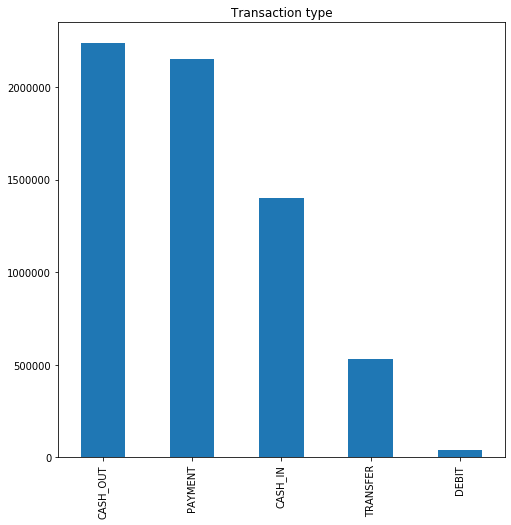

In [0]:
print(df.type.value_counts())

f, ax = plt.subplots(1, 1, figsize=(8, 8))
df.type.value_counts().plot(kind='bar', title="Transaction type", ax=ax, figsize=(8,8))
plt.show()

In [0]:
# Percentage of isFraud
print(len(df[df.isFraud == 1])/len(df))
print(len(df[df.isFraud == 0])/len(df))

0.001290820448180152
0.9987091795518198


There are 2 attributes that are intersting to look into: **isFraud** and **isFlaggedFraud** column. *isFraud* indicates the actual fraud transactions whereas *isFlaggedFraud* is what the system prevents transaction due to a threshold (Described when Transfer Amount > 200000)

In [0]:
print("Type of transactions when isFlaggedFraud is True: {}".format(set(df.loc[df.isFlaggedFraud == 1].type.drop_duplicates())))

# Since the type of transactions affected by isFlaggedFraud is True is only Transfers,
# We filter out the others, leaving only transactions of type Transfer inside.
dfTransfer = df.loc[df.type == 'TRANSFER']

# Filter out where the transactions are listed as isFlaggedFraud == 1
dfFlagged = df.loc[df.isFlaggedFraud == 1]

# We try to find the minimum amount where transaction is listed as isFlaggedFraud == 1.
print('\nMin amount transacted when isFlaggedFraud == 1 is {}'
.format(dfFlagged.amount.min()))

# Conversely, we filter out those where the transaction is listed as isFlaggedFraud == 0
dfNotFlagged = df.loc[df.isFlaggedFraud == 0]

# Next, we find the maximum amount when isFlaggedFraud == 0
print('\nMax amount transacted when isFlaggedFraud == 0 is {}'
.format(dfNotFlagged.amount.max()))

Type of transactions when isFlaggedFraud is True: {'TRANSFER'}

Min amount transacted when isFlaggedFraud == 1 is 353874.22

Max amount transacted when isFlaggedFraud == 0 is 92445516.64


Here, we see that the previous description where isFlaggedFraud will be set to 1 when Transfer Amount > 200000 is incorrect as the highest amount transacted when isFlaggedFraud == 0 is more than 200000.

However, let's take a closer look at the isFlaggedFraud column.

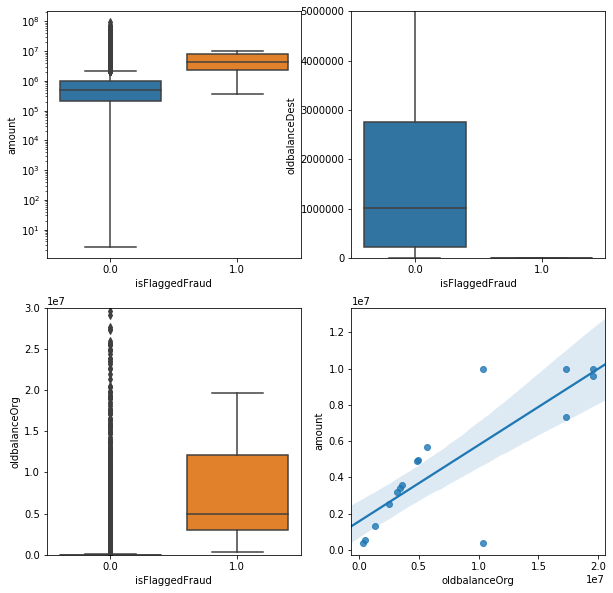

In [0]:
fig, axs = plt.subplots(2,2, figsize=(10,10))

amountWhenFlaggedFraud = sns.boxplot(x = 'isFlaggedFraud', y = 'amount', data = dfTransfer, ax = axs[0][0])
axs[0][0].set_yscale('log')

destWhenFlaggedFraud = sns.boxplot(x = 'isFlaggedFraud', y = 'oldbalanceDest', data = dfTransfer, ax = axs[0][1])
axs[0][1].set(ylim = (0,5e6))

orgWhenFlaggedFraud = sns.boxplot(x = 'isFlaggedFraud', y = 'oldbalanceOrg', data = dfTransfer, ax = axs[1][0])
axs[1][0].set(ylim = (0, 3e7))

amountandorg = sns.regplot(x = 'oldbalanceOrg',y = 'amount',data = dfFlagged, ax = axs[1][1])


It looks like **isFlaggedFraud** relies on **oldbalanceOrg**, which is 0 and some threshold on the amount variable. 

In [0]:
# Drop isFlaggedFraud from data
df.drop(["isFlaggedFraud"],axis = 1,inplace=True)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1.0,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0
1,1.0,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0
2,1.0,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0
3,1.0,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0
4,1.0,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0


Next, we take a look at **isFraud** factor.

In [0]:
print("Type of transactions when isFraud is True: {}".format(set(df.loc[df.isFraud == 1].type.drop_duplicates())))

Type of transactions when isFraud is True: {'CASH_OUT', 'TRANSFER'}


Since the type of transactions that are determined to be fraudulent is of type transfer and cash out, we remove all types of transactions that are not transfers or cashouts.

In [0]:
dfFraud = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]

# Relevance of account labels

According to data description, fraud is when there is a transfer to a fraudulent account which then tries to perform a cashout. Therefore, we try to find the similarities between the destination account of a transfer and the original account of a cashout. 

In [0]:
fraudDestTransfer = dfTransfer.loc[dfTransfer.isFraud == 1].nameDest.drop_duplicates()

dfCashout = df.loc[df.type == 'CASH_OUT']

fraudOrigCashout = dfCashout.loc[dfCashout.isFraud == 1].nameOrig.drop_duplicates()

print("Within fraudulent transactions, are there destinations for Transfers that are also originators for Cash_Out? {}".\
      format((fraudDestTransfer.isin(fraudOrigCashout).any())))

Within fraudulent transactions, are there destinations for Transfers that are also originators for Cash_Out? False


Therefore, we can drop the nameDest and nameOrig columns since there is no relationship between nameDest accounts of Transfer transactions and nameOrig of CashOut transactions

In [0]:
dfFraud.drop(["nameDest", "nameOrig"], axis = 1, inplace = True)
dfFraud.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
2,1.0,TRANSFER,181.00,181.0,0.0,0.0,0.00,1.0
3,1.0,CASH_OUT,181.00,181.0,0.0,21182.0,0.00,1.0
15,1.0,CASH_OUT,229133.94,15325.0,0.0,5083.0,51513.44,0.0
19,1.0,TRANSFER,215310.30,705.0,0.0,22425.0,0.00,0.0
24,1.0,TRANSFER,311685.89,10835.0,0.0,6267.0,2719172.89,0.0


# Data cleaning

In [0]:
# Binary encode type of transaction
dfFraud.loc[dfFraud.type == 'TRANSFER', 'type'] = 0
dfFraud.loc[dfFraud.type == 'CASH_OUT', 'type'] = 1
dfFraud.type = dfFraud.type.astype(int) 

dfIsFraudCol = dfFraud['isFraud']

dfIsFraud = dfFraud.loc[df.isFraud == 1]
dfNotFraud = dfFraud.loc[df.isFraud == 0]


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5208: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Input of latent variables

In [0]:
print('\nThe fraction of fraudulent transactions with \'oldBalanceDest\' = \
\'newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(dfIsFraud.loc[(dfIsFraud.oldbalanceDest == 0) & \
(dfIsFraud.newbalanceDest == 0) & (dfIsFraud.amount)]) / (1.0 * len(dfIsFraud))))

print('\nThe fraction of genuine transactions with \'oldBalanceDest\' = \
newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(dfNotFraud.loc[(dfNotFraud.oldbalanceDest == 0) & \
(dfNotFraud.newbalanceDest == 0) & (dfNotFraud.amount)]) / (1.0 * len(dfNotFraud))))


The fraction of fraudulent transactions with 'oldBalanceDest' = 'newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.4955558261293072

The fraction of genuine transactions with 'oldBalanceDest' = newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.0006176245277308345


The dataset has several transactions with 0 balances in the destination account before and after a non-zero ammount is transacted. The fraction of such transactions is much higher in fradulent cases compared to the genuine transactions. To remove the confusion between genuine and fraudulent transactions, we replace the 0 which originally denote the failure in transaction with -1 for fraudulent transactions.


In [0]:
dfFraud.loc[(dfFraud.oldbalanceDest == 0) & (dfFraud.newbalanceDest == 0) & (dfFraud.amount != 0), ['oldbalanceDest', 'newbalanceDest']] = -1

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



The zero balances problem was also found present in the original accounts, where a non-zero amount is transacted. This was rectified by changing the 0 value to a null value.

In [0]:
dfFraud.loc[(dfFraud.oldbalanceOrg == 0) & (dfFraud.newbalanceOrig == 0) & (dfFraud.amount != 0), ['oldbalanceOrg', 'newbalanceOrig']] = np.nan

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Undersampling data

As the data is severely filled with non-fraudulent transactions, we need to undersample the non-fraudulent transactions to match the number of fraudulent transactions

In [0]:
# Number of fraudulent transactions
print("Number of Fraud Data: {}".format(len(dfIsFraud)))

Number of Fraud Data: 8213


In [0]:
# Undersample fraudulent data
dfNotFraud = dfNotFraud.sample(n = 8213)
dfFraud = pd.concat([dfNotFraud,dfIsFraud])
print(len(dfFraud))

16426


# Feature engineering
Using the zero balances as the differentiating factor between fraudulent and genuine transactions, we can create two new features recording the errors between balances of the original account and destination account.

In [0]:
dfFraud['errorbalanceOrig'] = dfFraud.newbalanceOrig + dfFraud.amount - dfFraud.oldbalanceOrg
dfFraud['errorbalanceDest'] = dfFraud.newbalanceDest + dfFraud.amount - dfFraud.oldbalanceDest

# Data visualisation

We try to visualise the differences between fraudulent transactions and non-fraudulent transactions as follows:

Text(0.5, 1, 'Genuine Transactions')

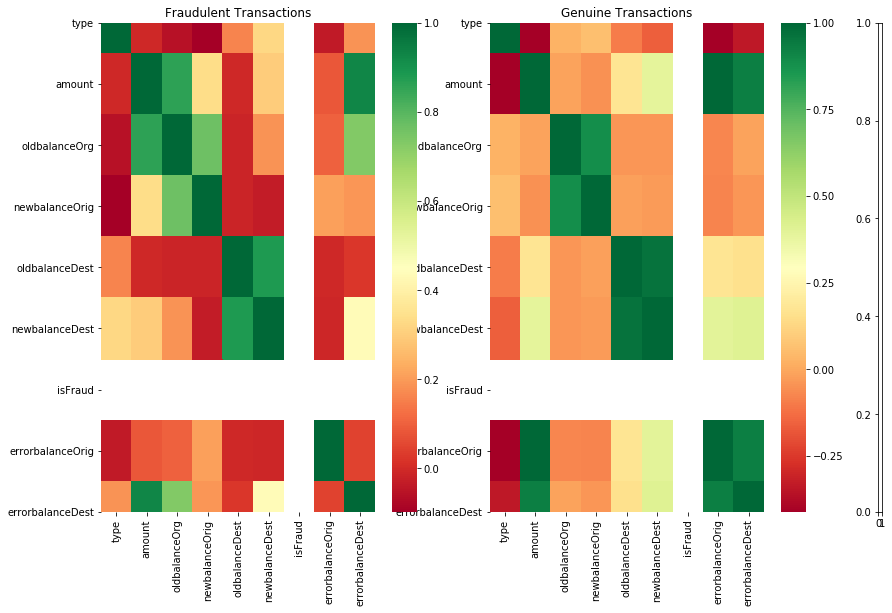

In [0]:
# Update with the cleaned data
dfIsFraud = dfFraud[dfFraud.isFraud == 1]
dfNotFraud = dfFraud[dfFraud.isFraud == 0]

grid_kws = {"width_ratios": (.9, .9, 0.01), "wspace": 0.2}
f, (ax1, ax2, cbar_ax) = plt.subplots(1, 3, gridspec_kw=grid_kws, \
                                     figsize = (14, 9))

fraud_corr = dfIsFraud.loc[:, dfFraud.columns != "step"].corr()
ax1 = sns.heatmap(fraud_corr, ax = ax1, cmap = "RdYlGn")
ax1.set_title("Fraudulent Transactions")


notfraud_corr = dfNotFraud.loc[:, dfFraud.columns != "step"].corr()
ax2 = sns.heatmap(notfraud_corr, ax = ax2, cmap = "RdYlGn")
ax2.set_title("Genuine Transactions")



# Train-Test Split

In [0]:
Y = dfFraud['isFraud']
del dfFraud['isFraud']
X = dfFraud

In [0]:
randomstate = 123

np.random.seed(randomstate)

trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.3, random_state = randomstate)

# Apply Logistic Regression

In [0]:
LR = LogisticRegression()
LR.fit(trainX, trainY)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
predictions = LR.predict(testX)

print("F1 Score: {}".format(f1_score(testY, predictions, average = 'weighted')))

print('AUPRC : {}'.format(average_precision_score(testY, predictions)))

F1 Score: 0.9208756613339916
AUPRC : 0.8724269984949414


# Apply Random Forest

In [0]:
rf = RandomForestClassifier()
rf.fit(trainX, trainY)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
rfPredict = rf.predict(testX)

print("F1 Score: {}".format(f1_score(testY, rfPredict, average = 'weighted')))

print('AUPRC : {}'.format(average_precision_score(testY, rfPredict)))

F1 Score: 0.9981737007722861
AUPRC : 0.9979753857454136


# Analysing Results

In [0]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

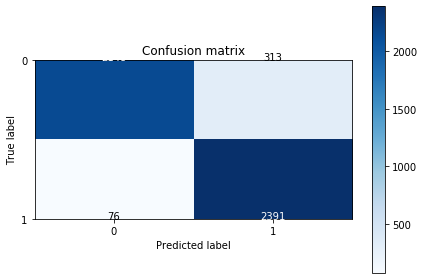

In [0]:
# Compute confusion matrix for logistic regression
lrConfM = confusion_matrix(y_true=testY, y_pred=predictions)

plt.figure()
plot_confusion_matrix(lrConfM
                      , classes=[0,1]
                      , title='Confusion matrix')
plt.show()

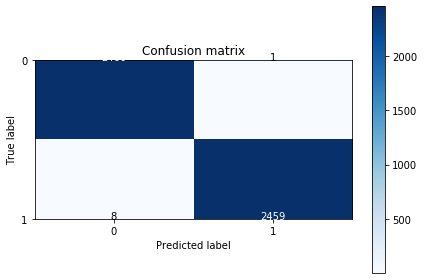

In [0]:
# Compute confusion matrix

rfConfM = confusion_matrix(testY, rfPredict)
plt.figure()
plot_confusion_matrix(rfConfM
                      , classes=[0,1]
                      , title='Confusion matrix')
plt.show()

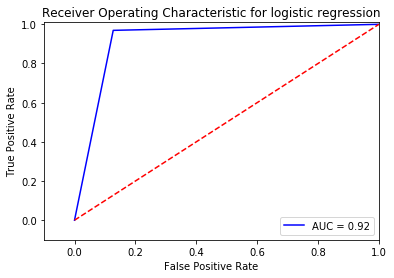

In [0]:
fpr, tpr, thresholds = roc_curve(testY, predictions)
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic for logistic regression')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

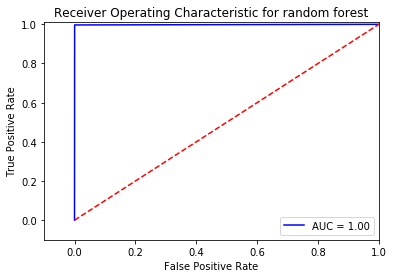

In [0]:
fpr, tpr, thresholds = roc_curve(testY, rfPredict)
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic for random forest')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()